In [1]:
# Day 1 Wrap Client Demographics
# 1.1 Import Libraries.

    # Manipulating Data
import pandas as pd
import numpy as np

    # Visualizing Data
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

    # Statistical Analysis
from scipy.stats import (
    ttest_ind,
    chi2_contingency,
    norm,
    mannwhitneyu,
    shapiro,
    probplot
)
from statsmodels.stats.proportion import (
    proportions_ztest,
    proportions_chisquare
)
import statsmodels.api as sm

import sys
sys.path.append("../src")

pd.set_option('display.float_format', '{:.2f}'.format)

client_url = "../data/clean_data_txt/df_full.csv"
df_clients = pd.read_csv(client_url)

df_clients.describe()

,client_id,client_tenure_years,client_tenure_months,age,number_of_accounts,balance,calls_6_months,logons_6_months
count,317235.00,317235.00,317235.00,317235.00,317235.00,317235.00,317235.00,317235.00
mean,5009953.90,12.18,152.12,48.53,2.26,160767.31,3.23,6.27
std,2873216.57,6.96,83.14,15.63,0.54,340813.13,2.19,2.18
min,555.00,2.00,33.00,17.00,1.00,23789.44,0.00,3.00
25%,2516332.00,6.00,82.00,34.50,2.00,41044.95,1.00,4.00
50%,5049612.00,11.00,137.00,50.00,2.00,69056.52,3.00,6.00
75%,7470491.00,16.00,193.00,61.00,2.00,151082.86,6.00,9.00
max,9999832.00,55.00,669.00,96.00,7.00,16320040.15,6.00,9.00


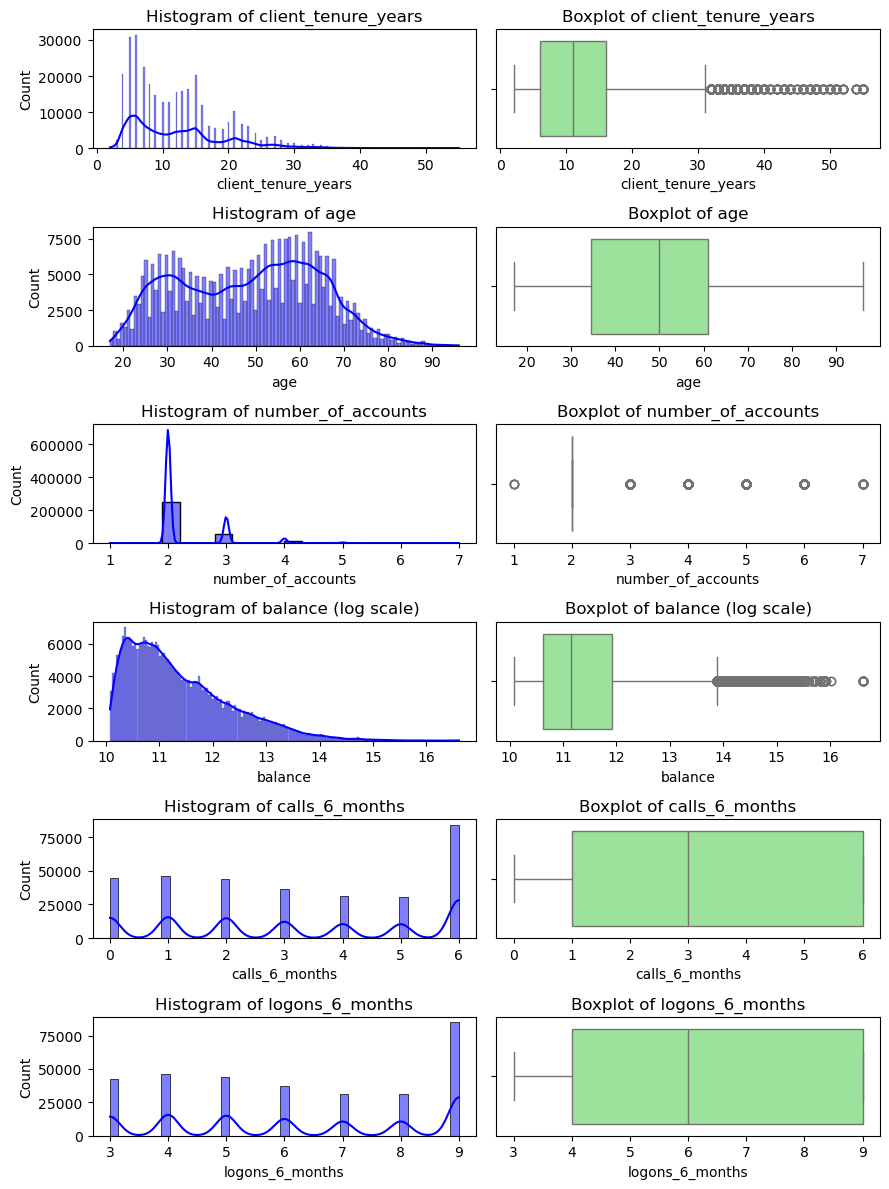

In [2]:
# List of numeric columns
numeric_cols = [
    'client_tenure_years',
    'age',
    'number_of_accounts',
    'balance',
    'calls_6_months',
    'logons_6_months'
]

plt.figure(figsize=(9, 12))
for i, col in enumerate(numeric_cols, 1):
    # Apply log transformation for 'balance' only
    data = df_clients[col]
    if col == 'balance':
        data = np.log1p(data)  # log(1 + x) to handle zeros safely

    # Histogram
    plt.subplot(len(numeric_cols), 2, 2*i - 1)
    sns.histplot(data, kde=True, bins='auto', color='blue')
    plt.title(f'Histogram of {col}' + (' (log scale)' if col == 'balance' else ''))
    plt.xlabel(col)
    plt.ylabel('Count')

    # Boxplot
    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.boxplot(x=data, color='lightgreen')
    plt.title(f'Boxplot of {col}' + (' (log scale)' if col == 'balance' else ''))
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# Distribution Insights for Client Variables

## 1. Client Tenure Years
- **Type**: Discrete integer
- **Distribution**: Right-skewed, possibly exponential
- **Skew**: Positive (long tail to the right)
- **Outliers**: A few clients with unusually long tenure, this is weird since the group was founded in 1975, so 42 yrs old according to research team!!!
- **Comment**: Most clients are relatively new (1–3 years), with a small group of long-standing clients.

## 2. Age
- **Type**: Continuous
- **Distribution**: Bimodal, possibly mixture of normals
- **Skew**: Slightly positive
- **Outliers**: Some very young and very old clients
- **Comment**: Two main age clusters suggest distinct client segments — possibly younger digital users and older legacy clients.

## 3. Number of Accounts
- **Type**: Discrete integer
- **Distribution**: Strong left skew, resembles geometric
- **Skew**: Positive
- **Outliers**: Clients with 3+ accounts are rare
- **Comment**: Most clients hold 2 accounts and the decline is rapid.

## 4. Balance (Log Scale)
- **Type**: Continuous (log-transformed)
- **Distribution**: Log-normal
- **Skew**: Reduced due to log scale, but still right-skewed
- **Outliers**: High balances still visible post-transform
- **Comment**: Most clients have modest balances, with a small group holding significantly more — typical wealth distribution.

## 5. Calls in 6 Months
- **Type**: Discrete integer
- **Distribution**: Multimodal, possibly zero-inflated Poisson
- **Skew**: Positive
- **Outliers**: Clients with 10+ calls are rare
- **Comment**: Many clients made no calls, while others show light engagement — may reflect digital vs. phone-preferred users.

## 6. Logons in 6 Months
- **Type**: Discrete integer
- **Distribution**: Multimodal, possibly compound Poisson
- **Skew**: Moderate positive
- **Outliers**: Heavy users with 100+ logons
- **Comment**: Usage patterns vary widely — some clients log in frequently, others rarely. Indicates behavioral segmentation potential.


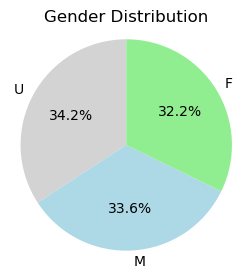

In [30]:
# Count gender values
gender_counts = df_clients['gender'].value_counts()

# Define color mapping
color_map = {'M': 'lightblue', 'F': 'lightgreen', 'U': 'lightgray'}
colors = [color_map.get(g, 'gray') for g in gender_counts.index]

# Plot pie chart
plt.figure(figsize=(3, 3))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

# Client Gender

- **Distribution**: About a third of the clients have not provided their gender in their accounts sign in (U). From those that have, males are slightly more than females. 

In [31]:
# Lets check for those outliers in tenure
df_clients['client_tenure_years'].describe()

count   70609.00
mean       12.05
std         6.87
min         2.00
25%         6.00
50%        11.00
75%        16.00
max        62.00
Name: client_tenure_years, dtype: float64

In [41]:
# Clients with more than 42 years tenure and describe
df_clients[df_clients['client_tenure_years'] >= 42].describe()

,client_tenure_years,client_tenure_months,age,number_of_accounts,balance,calls_6_months,logons_6_months
count,73.00,73.00,73.00,73.00,73.00,73.00,73.00
mean,48.40,584.93,58.53,2.49,356516.81,3.74,5.89
std,4.12,50.21,15.02,0.77,441584.84,2.24,2.18
min,42.00,504.00,18.00,2.00,14167.31,0.00,2.00
25%,46.00,561.00,45.00,2.00,70645.03,2.00,4.00
50%,48.00,576.00,62.00,2.00,151921.40,4.00,6.00
75%,50.00,610.00,70.50,3.00,420411.87,6.00,8.00
max,62.00,749.00,85.00,4.00,1874019.73,7.00,9.00


In [43]:
# Clients with less than 42 years tenure and describe
df_clients[df_clients['client_tenure_years'] < 42].describe()

,client_tenure_years,client_tenure_months,age,number_of_accounts,balance,calls_6_months,logons_6_months
count,70536.00,70536.00,70536.00,70536.00,70536.00,70536.00,70536.00
mean,12.02,150.21,46.43,2.26,147212.17,3.38,5.57
std,6.77,80.91,15.59,0.53,301231.81,2.24,2.35
min,2.00,33.00,13.50,1.00,13789.42,0.00,1.00
25%,6.00,82.00,32.50,2.00,37340.18,1.00,4.00
50%,11.00,136.00,47.00,2.00,63311.33,3.00,5.00
75%,16.00,192.00,59.00,2.00,137275.25,6.00,7.00
max,41.00,492.00,96.00,8.00,16320040.15,7.00,9.00


In [48]:
# print balance acumulated
not_outliers_bal = (df_clients[df_clients['client_tenure_years'] < 42]['balance'].sum())
outliers_bal = (df_clients[df_clients['client_tenure_years'] >= 42]['balance'].sum())
# ratio
outliers_bal / not_outliers_bal

np.float64(0.002506388119798458)

##### This clients represent the 2,5 % of the balance of the ones with less than 42 yrs tenure, keep them.